In [2]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
import shap

import sys
sys.path.append('../')
import utils

In [3]:
# Load dataset and add squared term
credit_score = pd.read_csv("../../data/credit_score.csv")
credit_score['R_EXPENDITURE_SQR'] = credit_score['R_EXPENDITURE']**2

# Select features
X = credit_score[['INCOME','R_DEBT_INCOME','R_EXPENDITURE','R_EXPENDITURE_SQR','R_ENTERTAINMENT','CAT_GAMBLING']].copy()

# One-hot encoding
X['GAMBLING_LOW'] = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
X.drop(columns=['CAT_GAMBLING'], inplace=True)

# Target variable
y = credit_score['CREDIT_SCORE']

X.head()


,INCOME,R_DEBT_INCOME,R_EXPENDITURE,R_EXPENDITURE_SQR,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,33269,16.0000,0.5797,0.336052,0.5065,0,1
1,77158,4.0909,0.3580,0.128164,0.5042,0,0
2,30917,17.3000,0.5698,0.324672,0.6178,0,1
3,80657,7.8000,0.4985,0.248502,0.5094,0,1
4,149971,16.0000,0.4604,0.211968,0.5150,0,1


In [4]:
# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Output the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     672.1
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:16:52   Log-Likelihood:                -4694.1
No. Observations:                1000   AIC:                             9404.
Df Residuals:                     992   BIC:                             9444.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               674.9545     21.51

# Plot of residuals

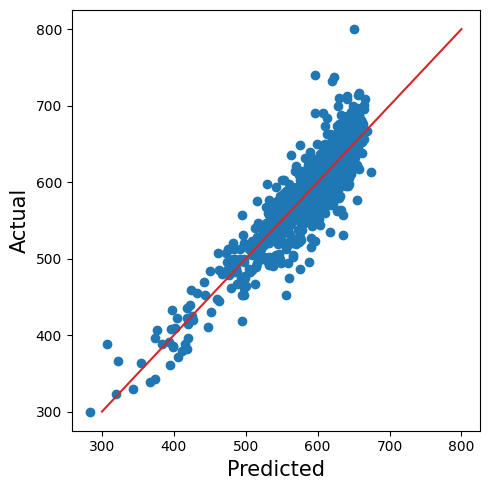

In [28]:
# Get model predictions
y_pred = model.predict(X)

# Plot predicted vs actual
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_pred,y)

# Plot y=x line
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.xlabel('Predicted',size=15)
plt.ylabel('Actual', size=15)

# Save figure
utils.save_fig("LM4_residuals")

# Feature importance (absolute t-statistic)

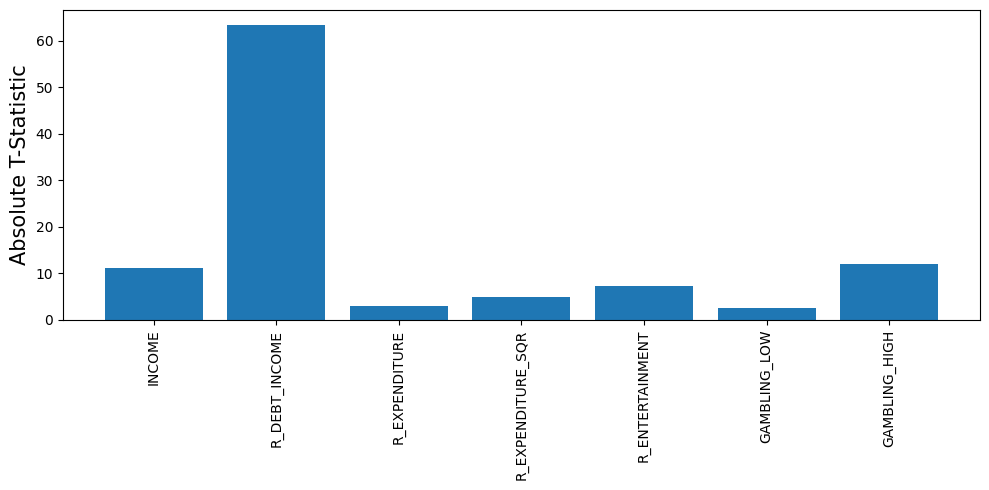

In [42]:
# Get the absolute values of the t-statistics from the model
t_statistic = model.tvalues[1:] # exclude the constant
abs_t_statistic = abs(t_statistic)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], abs_t_statistic)  

plt.ylabel('Absolute T-Statistic',size=15)
plt.xticks(rotation=90)

# Save figure
utils.save_fig("LM4_abs_t_statistic")

# T-statistic

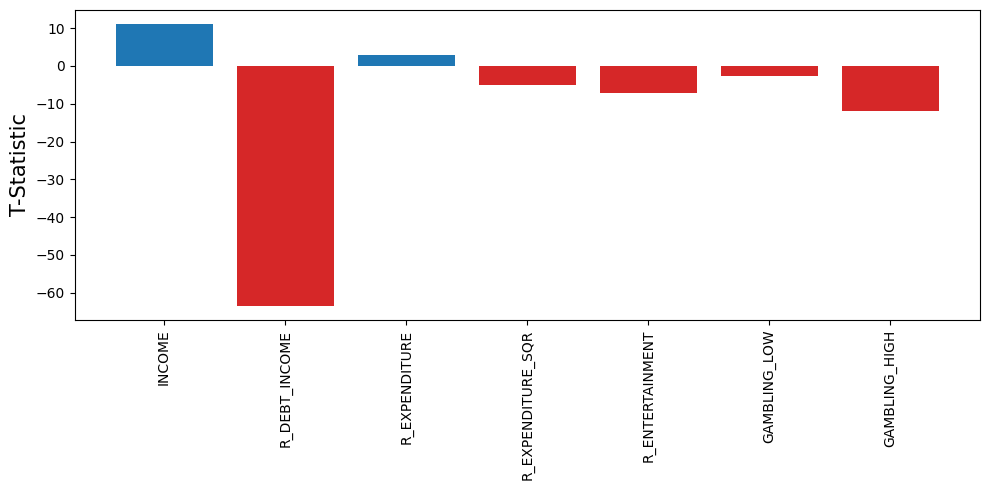

In [45]:
# Get bar colors based on the sign of the t-statistics
colors = ['tab:red' if t < 0 else 'tab:blue' for t in t_statistic]

plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], t_statistic, color=colors)

plt.ylabel('T-Statistic', size=15)
plt.xticks(rotation=90)

# Save figure
utils.save_fig("LM4_t_statistic")

## Weight plot

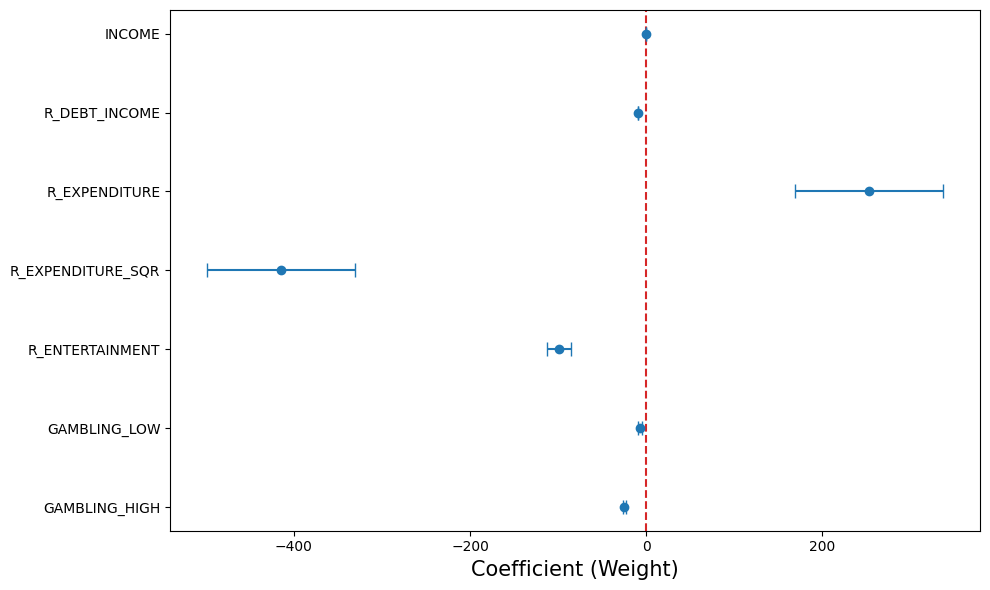

In [68]:
# Get coefficients and standard errors
coefficients = model.params[1:][::-1]
se = model.bse[1:][::-1]
features = X.columns[1:][::-1]

plt.figure(figsize=(10, 6))

# Plot vertical dotted line at x=0
plt.axvline(x=0, color='tab:red', linestyle='--')

# Plot the coefficients and error bars
plt.errorbar(coefficients, 
             features, 
             xerr=se, 
             fmt='o', 
             capsize=5)

plt.xlabel('Coefficient (Weight)', size=15)

# Save figure
utils.save_fig("LM4_weight_plot")

In [69]:
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X.drop(columns='const'))
X_scaled = pd.DataFrame(X_scaled, columns=X.columns[1:])
X_scaled = sm.add_constant(X_scaled)

# Fit a linear regression model with scaled features
model_scaled = sm.OLS(y, X_scaled).fit()

# Output the summary of the model
print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     672.1
Date:                Fri, 27 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:29:27   Log-Likelihood:                -4694.1
No. Observations:                1000   AIC:                             9404.
Df Residuals:                     992   BIC:                             9444.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               586.7120      0.84

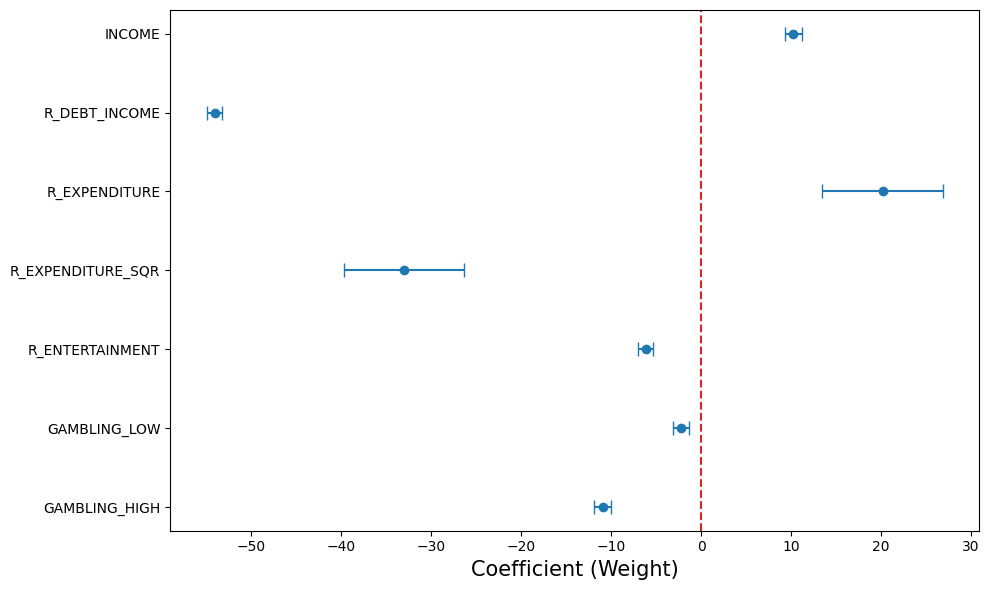

In [71]:
# Get coefficients and standard errors
coefficients = model_scaled.params[1:][::-1]
se = model_scaled.bse[1:][::-1]
features = X_scaled.columns[1:][::-1]

# Create a weight plot with scaled features
plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='tab:red', linestyle='--')
plt.errorbar(coefficients, 
             features, 
             xerr=se, 
             fmt='o', 
             capsize=5)
plt.xlabel('Coefficient (Weight)', size=15)

# Save figure
utils.save_fig("LM4_weight_plot_scaled")

## Effect plot

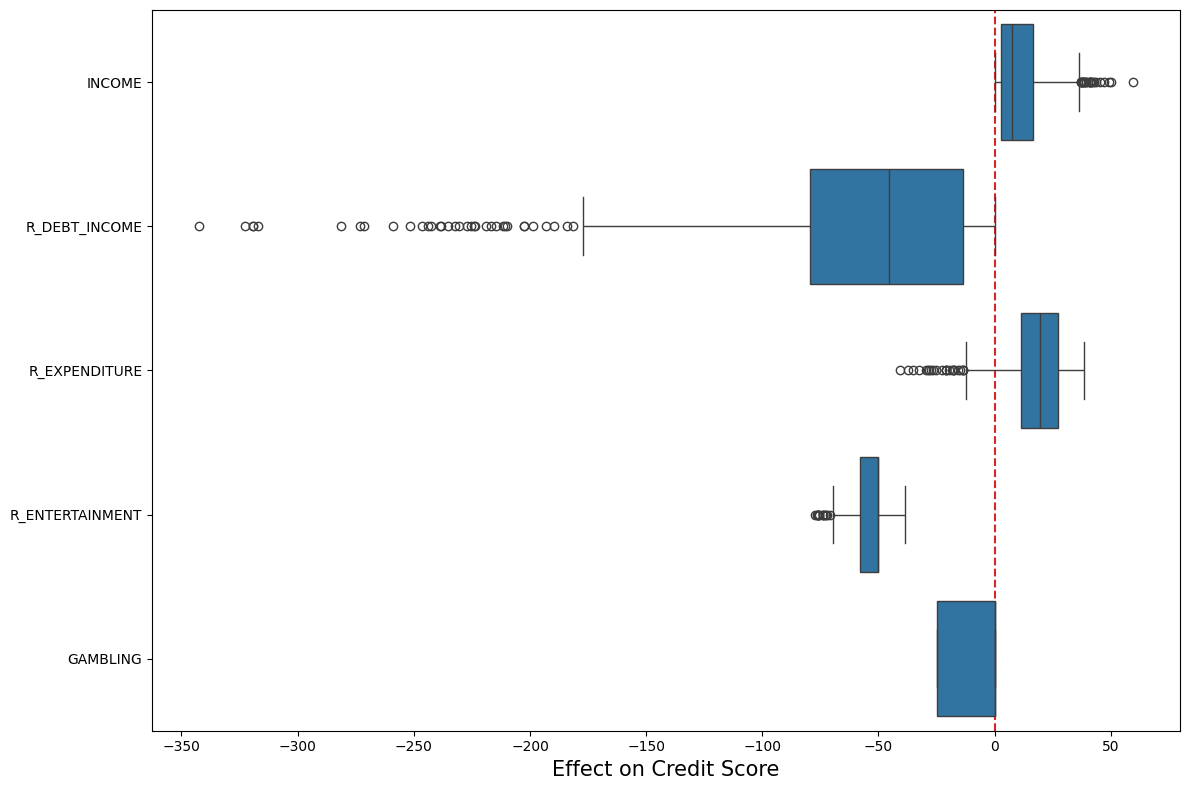

In [81]:
# Calculate the feature effects 
feature_effects = X * model.params

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
plt.axvline(x=0, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.xlabel("Effect on Credit Score", size=15)

# Save figure
utils.save_fig("LM4_effect_plot")


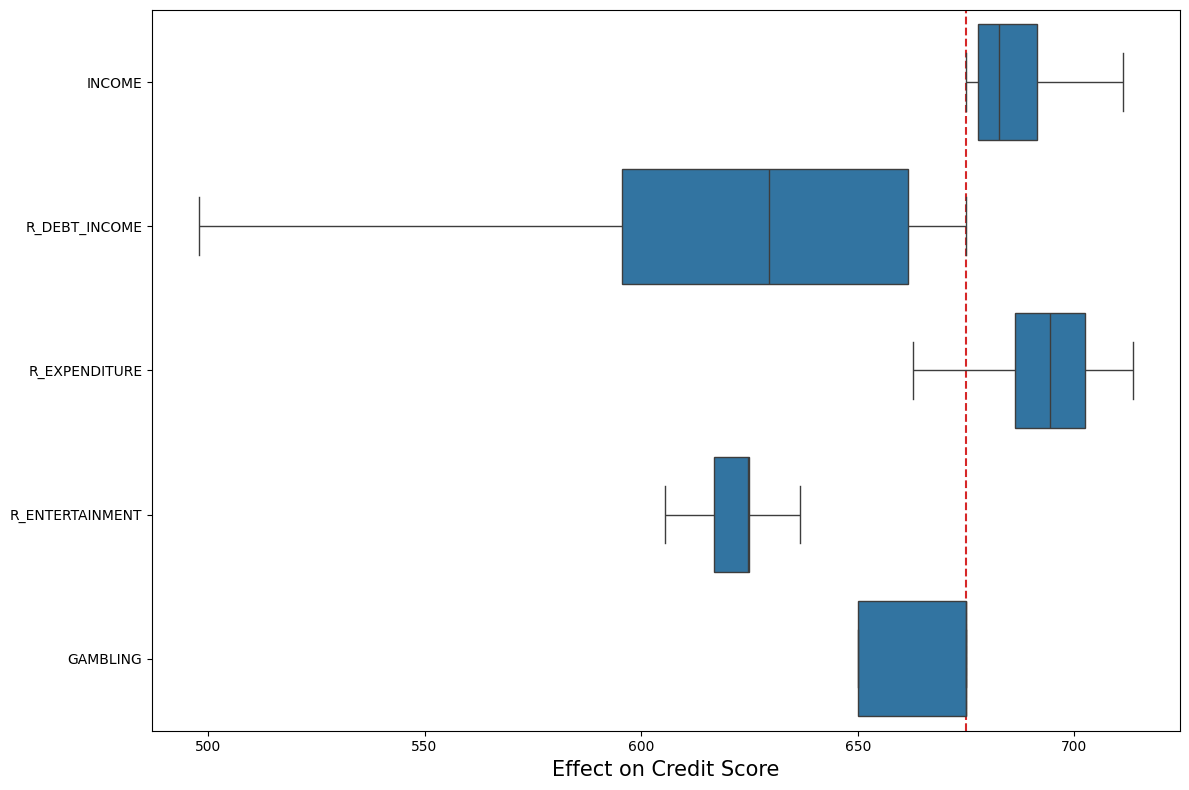

In [90]:
# Calculate the feature effects
feature_effects = X * model.params
const = feature_effects['const'][0] 

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Add the constant to the feature effects
feature_effects = feature_effects + const

# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
plt.axvline(x=const, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

# Save figure
utils.save_fig("LM4_adjusted_effect_plot")

## Individual effect plot

444


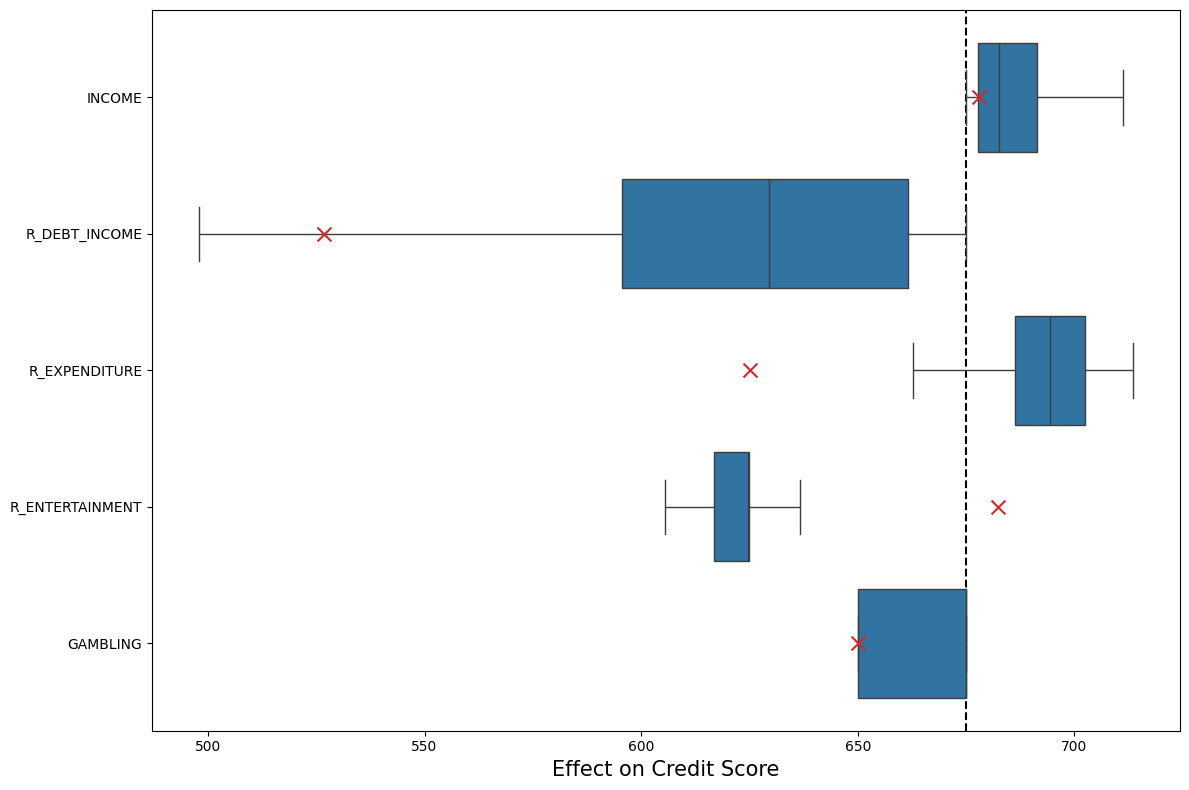

In [102]:
# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

idx = 0  # You can change this to any valid index in your dataset
ind_feature_effect = X.iloc[idx] * model.params[1:]
print(y[idx])

# Combine feature effects for related features
ind_feature_effect['R_EXPENDITURE'] = ind_feature_effect['R_EXPENDITURE'] + ind_feature_effect['R_EXPENDITURE_SQR']
ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
ind_feature_effect.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

# Add the constant to the feature effects
ind_feature_effect = ind_feature_effect + const

for i, feature in enumerate(ind_feature_effect):
    plt.scatter(feature, i, c='tab:red', marker='x', s=100, zorder=10)

# Save figure
utils.save_fig("LM4_individual_effect_plot")

444
625


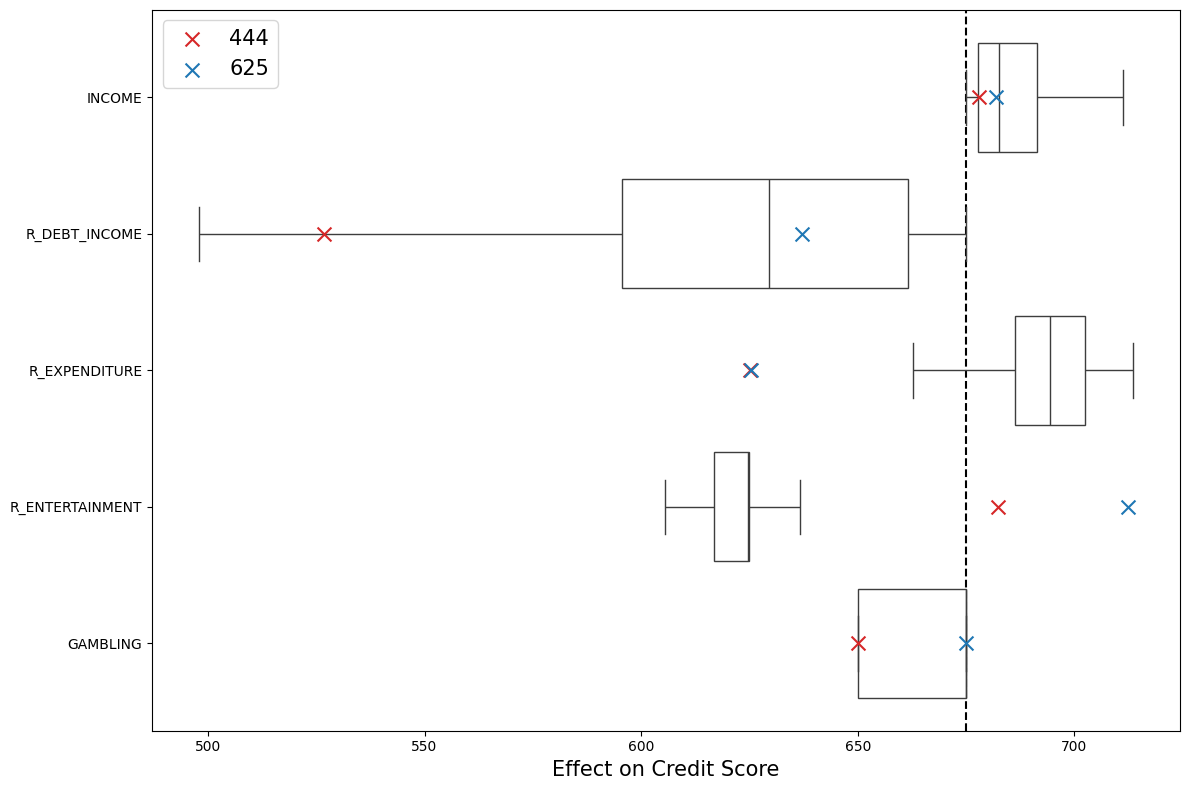

In [101]:
# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="white", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

colors = ['tab:red','tab:blue']
for idx in [0,1]:
    ind_feature_effect = X.iloc[idx] * model.params[1:]
    print(y[idx])

    # Combine feature effects for related features
    ind_feature_effect['R_EXPENDITURE'] = ind_feature_effect['R_EXPENDITURE'] + ind_feature_effect['R_EXPENDITURE_SQR']
    ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
    ind_feature_effect.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

    # Add the constant to the feature effects
    ind_feature_effect = ind_feature_effect + const

    for i, feature in enumerate(ind_feature_effect):
        if i == 0:
            plt.scatter(feature, i, c=colors[idx], marker='x', s=100, zorder=10,label=y[idx])
        else:
            plt.scatter(feature, i, c=colors[idx], marker='x', s=100, zorder=10)

plt.legend(fontsize=15)

# Save figure
utils.save_fig("LM4_individual_effect_plot_2")

# PDPs

In [5]:
# Fit a linear regression model with only debt-to-income ratio
model_income = sm.OLS(y, X[['const','R_DEBT_INCOME']]).fit()

print(model_income.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2782.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):          7.17e-291
Time:                        18:18:37   Log-Likelihood:                -4902.2
No. Observations:                1000   AIC:                             9808.
Df Residuals:                     998   BIC:                             9818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           643.1667      1.486    432.810

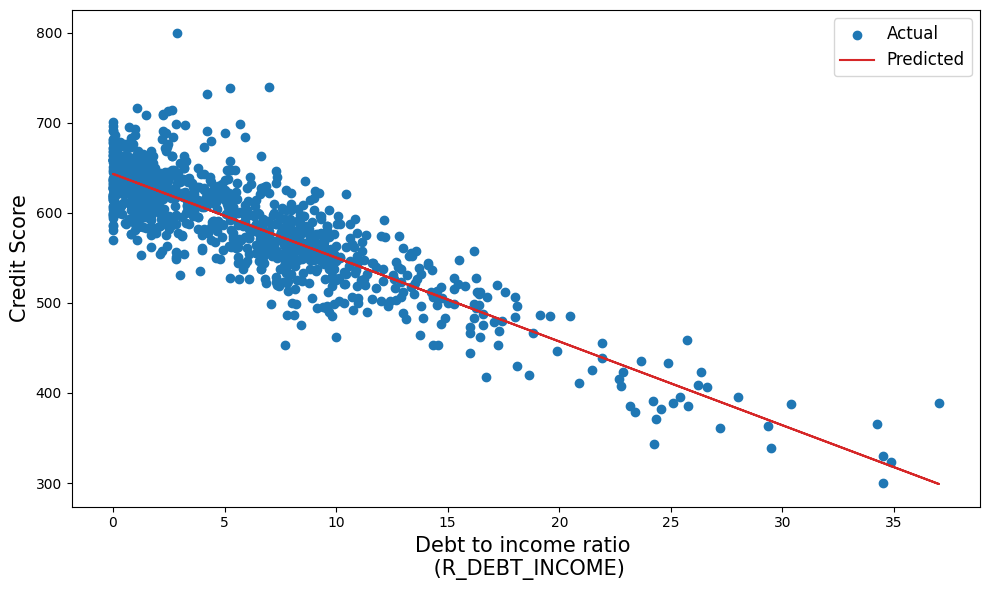

In [6]:
# Plot credit score vs income
plt.figure(figsize=(10, 6))
plt.scatter(X['R_DEBT_INCOME'], y,label='Actual')

# Plot the regression line
plt.plot(X['R_DEBT_INCOME'], model_income.predict(X[['const','R_DEBT_INCOME']]), color='tab:red',label='Predicted')

plt.xlabel('Debt to income ratio \n (R_DEBT_INCOME)', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

# Save figure
utils.save_fig("LM4_model_income")

In [11]:
# Create a list of values for the feature
feature_values = np.linspace(X['R_DEBT_INCOME'].min(), X['R_DEBT_INCOME'].max(), 100)
X_pdp = X.copy()

plt.figure(figsize=(10, 6))

all_preds = []
for i,row in X_pdp.iterrows():

    preds = []
    for value in feature_values:

        # replace the value of the feature and get prediction
        row['R_DEBT_INCOME'] = value
        pred = model.predict(row.values)
        preds.append(pred)

    all_preds.append(preds)

    # plot individual prediction line
    plt.plot(feature_values, preds, color='black',alpha=0.02)

# plot average prediction line
average_preds = np.mean(all_preds,axis=0)
plt.plot(feature_values, average_preds, color='r',linewidth=2,label='PDP',linestyle='--')

plt.xlabel('Debt to income ratio \n (R_DEBT_INCOME)', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

# Save figure
utils.save_fig("LM4_pdp_income")

## SHAP values

In [ ]:
# Calculate SHAP values
explainer = shap.KernelExplainer(model.predict,X)
shap_values = explainer(X)

In [10]:
shap.plots.waterfall(shap_values[0], show=False)

# Save figure
utils.save_fig("LM4_shap_waterfall")

In [165]:
preds = model.predict(X)

# calculate average prediction
print(np.mean(preds))

586.7119999999949


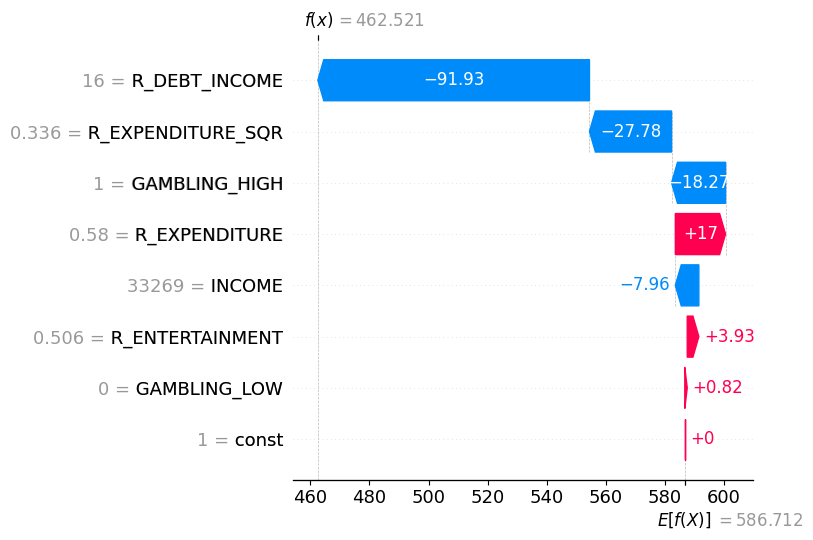

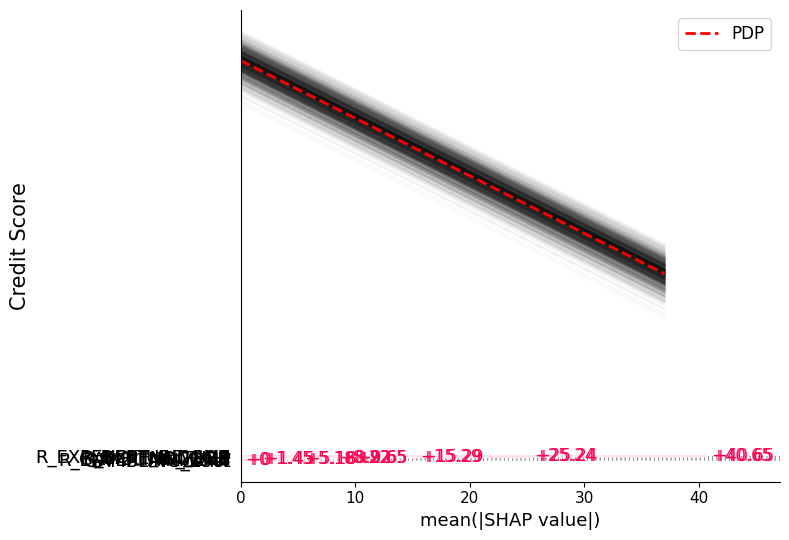

In [13]:
# SHAP bar plot
shap.plots.bar(shap_values)

# Save figure
utils.save_fig("LM4_shap_bar")